In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/Users/juliankimura/Desktop/deepomics')
import deepomics.neuralnetwork as nn
from deepomics import learn, utils
from models import vae_model

import theano
import theano.tensor as T
from lasagne import layers

np.random.seed(247)   # for reproducibility

In [2]:
def load_dataset(data_path):
    import gzip
    def load_mnist_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 28*28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images(os.path.join(data_path,'train-images-idx3-ubyte.gz'))
    y_train = load_mnist_labels(os.path.join(data_path,'train-labels-idx1-ubyte.gz'))
    X_test = load_mnist_images(os.path.join(data_path,'t10k-images-idx3-ubyte.gz'))
    y_test = load_mnist_labels(os.path.join(data_path,'t10k-labels-idx1-ubyte.gz'))

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


data_path = '/Users/juliankimura/Desktop/data/MNIST'
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(data_path)


In [3]:
shape = (None, X_train.shape[1])
network, placeholders, optimization = vae_model.model(shape)

In [4]:
# build neural network class
nnmodel = nn.NeuralNet(network, placeholders)
nnmodel.inspect_layers()

# set output file paths
output_name = 'MNIST_vae'
results_path = utils.make_directory(data_path, 'Results')
results_path = utils.make_directory(results_path, output_name)
file_path = os.path.join(results_path, output_name)
nntrainer = nn.NeuralTrainer(nnmodel, optimization, save='best', file_path=file_path)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 784)
layer2: 
shape:(None, 200)
parameters: W, b
layer3: 
shape:(None, 100)
parameters: W, b
layer4: 
shape:(None, 2)
parameters: W, b
layer5: 
shape:(None, 2)
parameters: W, b
layer6: 
shape:(None, 2)
layer7: 
shape:(None, 100)
parameters: W, b
layer8: 
shape:(None, 200)
parameters: W, b
layer9: 
shape:(None, 784)
parameters: W, b
----------------------------------------------------------------------------
compiling model
True


In [5]:
# train model
learn.train_minibatch(nntrainer, data={'train': X_train, 'valid': X_val}, 
                              batch_size=100, num_epochs=500, patience=10, verbose=0)


  valid loss:		525.08398
  valid squared loss:	0.21679
saving model parameters to: /Users/juliankimura/Desktop/data/MNIST/Results/MNIST_vae/MNIST_vae_best.pickle

  valid loss:		477.13197
  valid squared loss:	0.18031
saving model parameters to: /Users/juliankimura/Desktop/data/MNIST/Results/MNIST_vae/MNIST_vae_best.pickle

  valid loss:		404.12451
  valid squared loss:	0.13074
saving model parameters to: /Users/juliankimura/Desktop/data/MNIST/Results/MNIST_vae/MNIST_vae_best.pickle

  valid loss:		340.13735
  valid squared loss:	0.10233
saving model parameters to: /Users/juliankimura/Desktop/data/MNIST/Results/MNIST_vae/MNIST_vae_best.pickle

  valid loss:		296.38624
  valid squared loss:	0.08709
saving model parameters to: /Users/juliankimura/Desktop/data/MNIST/Results/MNIST_vae/MNIST_vae_best.pickle

  valid loss:		269.32088
  valid squared loss:	0.07866
saving model parameters to: /Users/juliankimura/Desktop/data/MNIST/Results/MNIST_vae/MNIST_vae_best.pickle

  valid loss:		252.34

/Users/juliankimura/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


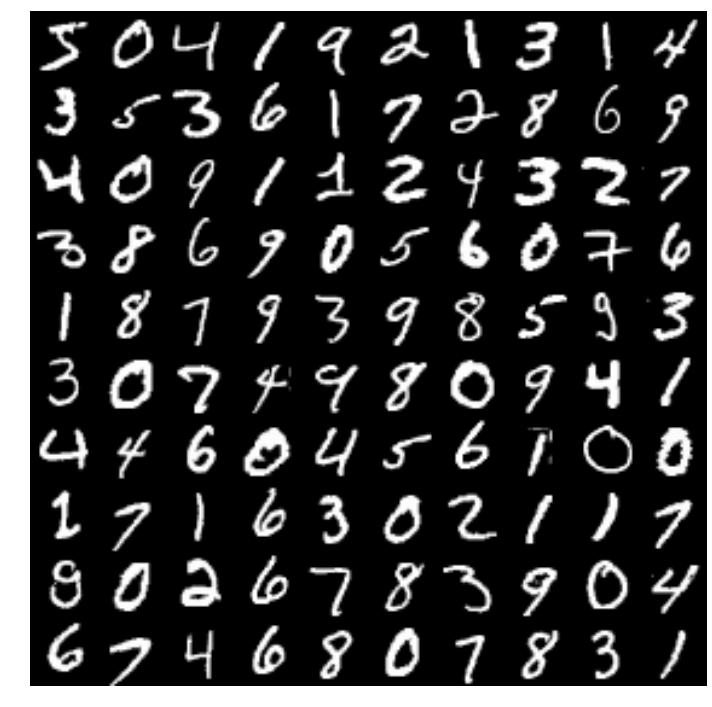

In [6]:
num_steps = 10
samples = X_train[:num_steps*num_steps,:]
fig = plt.figure()
plt.imshow((samples.reshape(num_steps, num_steps, 28, 28)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_steps*28, num_steps*28)), cmap='gray')
plt.axis('off')
fig.set_size_inches(10,10)

/Users/juliankimura/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


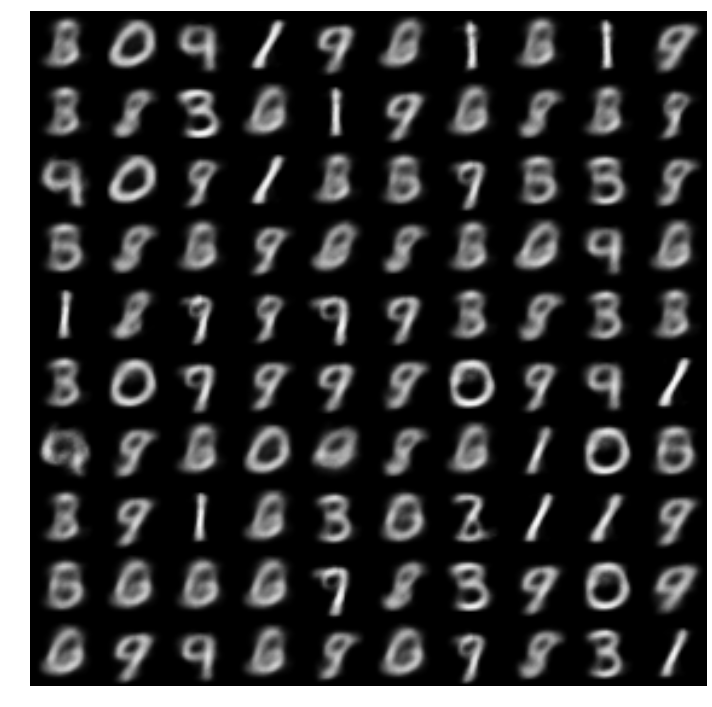

In [7]:
generated_x = layers.get_output(nnmodel.network['decode_mu'], deterministic=True)
gen_fn = theano.function([nnmodel.placeholders['inputs']], generated_x)
num_grid = 10
k = 0
reconstructed_samples = []
for i in range(num_grid):
    for j in range(num_grid):
        reconstructed_samples.append(gen_fn(np.expand_dims(samples[k], axis=0)))
        k += 1
reconstructed_samples = np.array(reconstructed_samples)        

               
fig = plt.figure()
plt.imshow((reconstructed_samples.reshape(num_grid, num_grid, 28, 28)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_grid*28, num_grid*28)), cmap='gray')
plt.axis('off')
fig.set_size_inches(10,10)



/Users/juliankimura/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


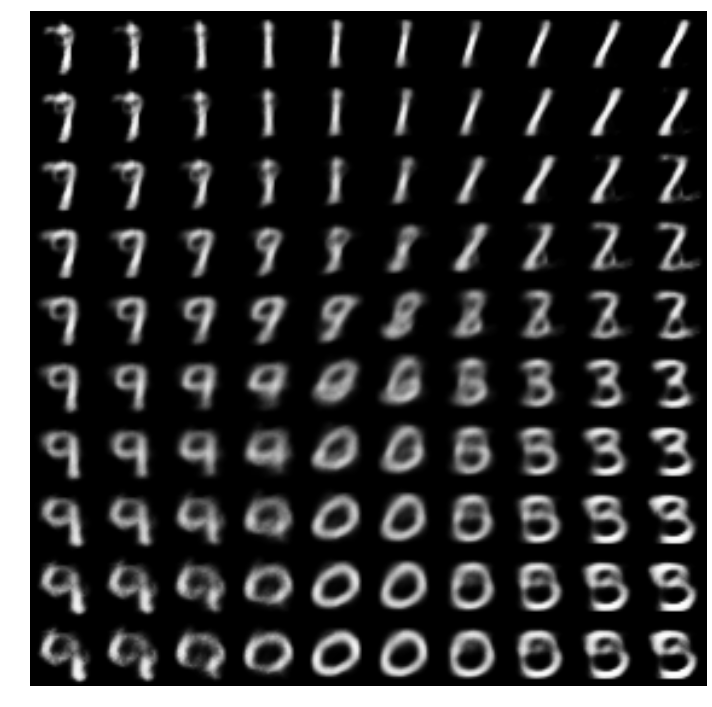

In [9]:
z_var = T.vector()
generated_x = layers.get_output(nnmodel.network['decode_mu'], {nnmodel.network['encode_mu']: z_var}, deterministic=True)
gen_fn = theano.function([z_var], generated_x)
num_grid = 10
pos = np.linspace(-3, 3, num_grid)
generated_samples = []
for i in range(num_grid):
    for j in range(num_grid):
        z = np.asarray([pos[i], pos[j]], dtype=theano.config.floatX)
        generated_samples.append(gen_fn(z))
generated_samples = np.array(generated_samples)        
                
     
fig = plt.figure()
plt.imshow((generated_samples.reshape(num_grid, num_grid, 28, 28)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_grid*28, num_grid*28)), cmap='gray')
plt.axis('off')
fig.set_size_inches(10,10)